### BBC-Text Analysis

In [1]:
# import the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.model_selection import GridSearchCV

from sklearn.utils import resample
from sklearn.metrics import roc_curve, roc_auc_score


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re

### General Text EDA

In [2]:
df=pd.read_csv('bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [4]:
df['category'].nunique()

5

In [5]:
print(df['category'].unique())

['tech' 'business' 'sport' 'entertainment' 'politics']


In [6]:
df.value_counts('category')

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

<Axes: xlabel='category'>

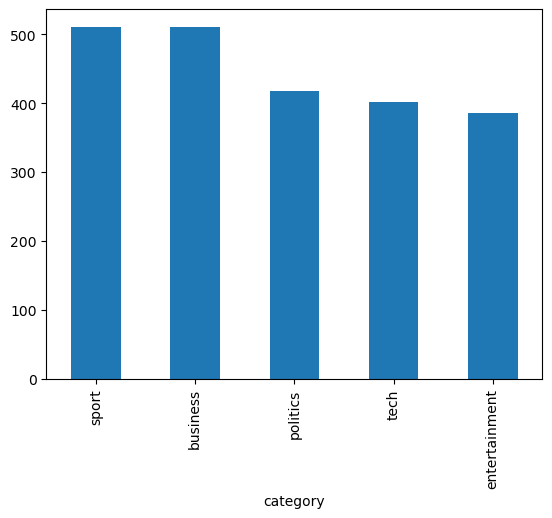

In [7]:
df['category'].value_counts().plot(kind='bar')

### Duplicated Entries


In [8]:
df['text'].duplicated().sum()

99

In [9]:
# Check for duplicates
duplicate_rows = df[df.duplicated('text')]

# Display the duplicate rows
print("Duplicate Rows: ")
print(duplicate_rows)

Duplicate Rows: 
           category                                               text
85         politics  hague  given up  his pm ambition former conser...
301        politics  fox attacks blair s tory  lies  tony blair lie...
496            tech  microsoft gets the blogging bug software giant...
543        business  economy  strong  in election year uk businesse...
582   entertainment  ray dvd beats box office takings oscar-nominat...
...             ...                                                ...
2206       politics  kennedy questions trust of blair lib dem leade...
2207           tech  california sets fines for spyware the makers o...
2213           tech  progress on new internet domains by early 2005...
2215           tech  junk e-mails on relentless rise spam traffic i...
2217           tech  rings of steel combat net attacks gambling is ...

[99 rows x 2 columns]


In [10]:
df.iloc[20]['text'] 

'security warning over  fbi virus  the us federal bureau of investigation is warning that a computer virus is being spread via e-mails that purport to be from the fbi.  the e-mails show that they have come from an fbi.gov address and tell recipients that they have accessed illegal websites. the messages warn that their internet use has been monitored by the fbi s internet fraud complaint center. an attachment in the e-mail contains the virus  the fbi said. the message asks recipients to click on the attachment and answer some questions about their internet use. but rather than being a questionnaire  the attachment contains a virus that infects the recipient s computer  according to the agency. it is not clear what the virus does once it has infected a computer. users are warned never to open attachment from unsolicited e-mails or from people they do not know.   recipients of this or similar solicitations should know that the fbi does not engage in the practice of sending unsolicited e-

In [11]:
df.iloc[1679]['text']

'security warning over  fbi virus  the us federal bureau of investigation is warning that a computer virus is being spread via e-mails that purport to be from the fbi.  the e-mails show that they have come from an fbi.gov address and tell recipients that they have accessed illegal websites. the messages warn that their internet use has been monitored by the fbi s internet fraud complaint center. an attachment in the e-mail contains the virus  the fbi said. the message asks recipients to click on the attachment and answer some questions about their internet use. but rather than being a questionnaire  the attachment contains a virus that infects the recipient s computer  according to the agency. it is not clear what the virus does once it has infected a computer. users are warned never to open attachment from unsolicited e-mails or from people they do not know.   recipients of this or similar solicitations should know that the fbi does not engage in the practice of sending unsolicited e-

In [12]:
import pandas as pd

def count_unique_text_duplicates_by_category(df, category_column, text_column):
    # Group by the category column
    grouped = df.groupby(category_column)
    
    # Initialize a dictionary to keep track of duplicates count by category
    category_duplicates_count = {}
    
    # Iterate over each group
    for category, group in grouped:
        # Find duplicated rows in the text column within the group
        duplicates = group[text_column].duplicated(keep=False)
        
        # Extract the duplicated rows
        duplicated_rows = group[duplicates]
        
        # Count unique duplicated text entries
        num_unique_duplicates = duplicated_rows[text_column].nunique()
        
        if num_unique_duplicates > 0:
            category_duplicates_count[category] = num_unique_duplicates
    
    # Print the number of unique duplicate text entries for each category
    for category, count in category_duplicates_count.items():
        print(f"Category '{category}' has {count} unique duplicated text entries.")


count_unique_text_duplicates_by_category(df, 'category', 'text')


Category 'business' has 7 unique duplicated text entries.
Category 'entertainment' has 17 unique duplicated text entries.
Category 'politics' has 14 unique duplicated text entries.
Category 'sport' has 7 unique duplicated text entries.
Category 'tech' has 54 unique duplicated text entries.


In [13]:
df.drop_duplicates(subset='text', inplace=True)
df['text'].duplicated().sum()

0

##### **Removing Duplicates**

```Removing duplicates``` involves identifying and eliminating repeated entries from a dataset to ensure uniqueness and accuracy. This step is crucial in data cleaning to avoid redundancy and improve the quality of analysis.
<hr>

In [14]:
def count_articles_by_category(df, category_column):
    # Count the number of articles in each category
    category_counts = df[category_column].value_counts()
   
    
    # Print the article count for each category
    for category, count in category_counts.items():
        print(f"Category '{category}' has {count} articles.")

count_articles_by_category(df, 'category')

Category 'sport' has 504 articles.
Category 'business' has 503 articles.
Category 'politics' has 403 articles.
Category 'entertainment' has 369 articles.
Category 'tech' has 347 articles.


In [15]:
# Distribution of Document Lengths

# Tokenize the text
tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df['text'].apply(tokenizer.tokenize)

# Calculate the document lengths
df['doc_len'] = df['tokens'].apply(len)

# Display the first few rows of the DataFrame
df.head()


,category,text,tokens,doc_len
0,tech,tv future in the hands of viewers with home th...,"[tv, future, in, the, hands, of, viewers, with...",750
1,business,worldcom boss left books alone former worldc...,"[worldcom, boss, left, books, alone, former, w...",300
2,sport,tigers wary of farrell gamble leicester say ...,"[tigers, wary, of, farrell, gamble, leicester,...",248
3,sport,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, in, fa, cup, premie...",349
4,entertainment,ocean s twelve raids box office ocean s twelve...,"[ocean, s, twelve, raids, box, office, ocean, ...",269


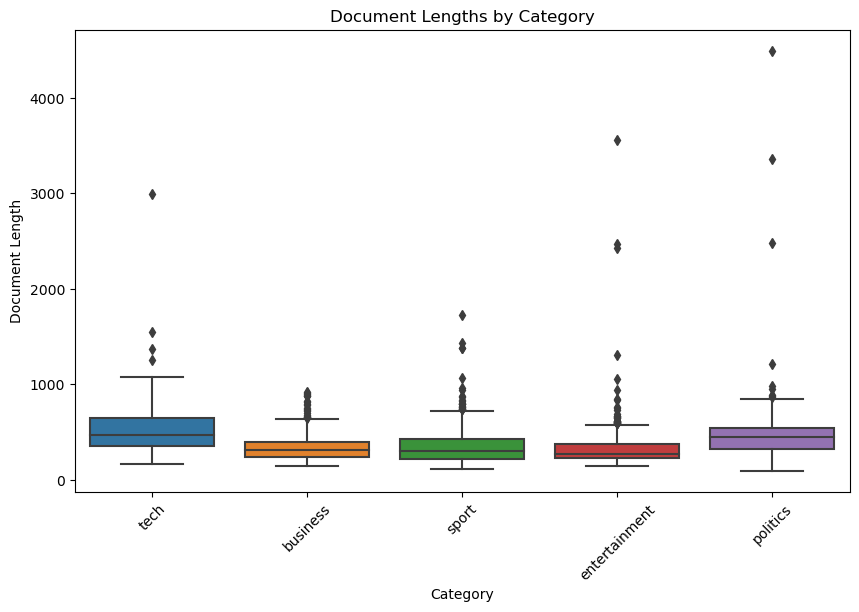

In [16]:
# Violin Plot for Document Lengths for each category

# Create a violin plot for the document lengths
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='category', y='doc_len')
plt.title('Document Lengths by Category')
plt.xlabel('Category')
plt.ylabel('Document Length')
plt.xticks(rotation=45)
plt.show()

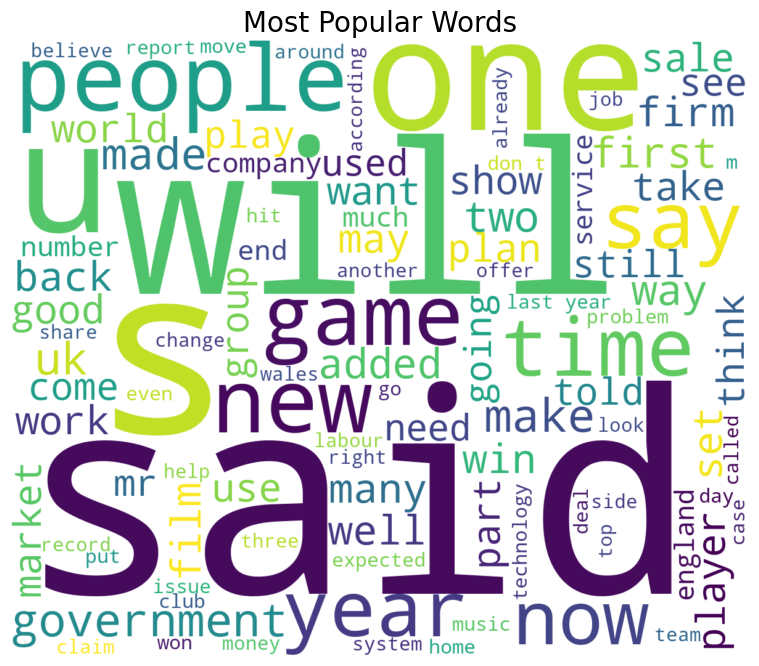

In [17]:
# Word Cloud Top 100 Words
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordlist= ' '.join(df['text'].tolist())

plt.rcParams['figure.figsize']=(10,8)
wordcloud= WordCloud(background_color='white',width=1200,height=1000,max_words=100).generate(wordlist)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Popular Words',fontsize=20)
plt.axis('off')
plt.show()

In [18]:
df['text'].sample()

456    boothroyd calls for lords speaker betty boothr...
Name: text, dtype: object

### General Text Preprocessing


In [19]:
# Preprocess the text

# Define a function to preprocess the text

def preprocess_text(text):

    # Remove non-word characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert text to lowercase
    text = text.lower()

    # Remove HTML Tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and digits

    text = re.sub("(\\d|\\W)+", " ", text)

    
    return text

# Apply the function to preprocess the text
df['clean_text'] = df['text'].apply(preprocess_text)

print('initial: \n',df['text'].head())
print('cleaned: \n',df['clean_text'].head())

initial: 
 0    tv future in the hands of viewers with home th...
1    worldcom boss  left books alone  former worldc...
2    tigers wary of farrell  gamble  leicester say ...
3    yeading face newcastle in fa cup premiership s...
4    ocean s twelve raids box office ocean s twelve...
Name: text, dtype: object
cleaned: 
 0    tv future in the hands of viewers with home th...
1    worldcom boss left books alone former worldcom...
2    tigers wary of farrell gamble leicester say th...
3    yeading face newcastle in fa cup premiership s...
4    ocean s twelve raids box office ocean s twelve...
Name: clean_text, dtype: object


##### **Text Preprocessing**

```Text preprocessing``` involves cleaning and preparing text data for analysis. Key steps include:

- **Removing Non-Words**: Eliminate non-word characters (e.g., numbers, punctuation) to focus on meaningful text.
- **Converting to Lowercase**: Transform all text to lowercase to ensure uniformity and avoid case sensitivity issues.
- **Removing HTML Tags**: Strip out HTML tags to clean up text extracted from web pages.
- **Removing Special Characters**: Remove characters that do not contribute to the meaning (e.g., `@`, `#`, `&`).
<hr>

In [20]:
def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        #removes trailing and leading whitespaces
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

#load a set of stop words
stopwords=list(get_stop_words("stopwords.txt"))
print(stopwords)



['general', 'want', 'our', 'last', 'between', 'parts', 'well', 'years', 'asked', 'should', 'take', 'greater', 'become', 'off', 'each', 'area', 'know', 'place', 'known', 'were', 'up', 'i', 'later', 'even', 'two', 'number', 'taken', 'evenly', 'how', 'working', 'seems', 'higher', 'having', 'need', 'made', 'state', 'latest', 'f', 'g', 'thoughts', 'think', 'toward', 'sides', 'finds', 'everybody', 'yours', 'myself', 'everywhere', 'along', 'let', 'r', 'she', 'case', 'and', 'b', 'high', 'could', 'newer', 'among', 'thought', 'itself', 'also', 'really', 'get', 'often', 'out', 'that', 'was', 'like', 'interests', 'different', 'but', 'interested', 'v', 'face', 'cases', 'backs', 'part', 'is', 'gave', 'groups', 'on', 'backing', 'w', 'most', 'by', 'y', 'within', 'show', 'does', 'enough', 'ways', 'some', 'necessary', 's', 'anybody', 'every', 'a', 'old', 'or', 'herself', 't', 'has', 'must', 'worked', 'states', 'again', 'together', 'long', 'generally', 'into', 'possible', 'three', 'interesting', 'likely'

##### **Stopwords**

```Stopwords``` are common words that are often filtered out in text processing because they do not carry significant meaning. Examples include **"the"**, **"is"**, and **"and"**. Removing stopwords helps improve the focus of text analysis and **NLP** tasks by reducing noise and emphasizing more meaningful words.
<hr>




In [21]:
# Remove stop words
def remove_stopwords(text,stopwords):
    tokens = word_tokenize(text)
    filtered_tokens = [w for w in tokens if w not in stopwords]
    return " ".join(filtered_tokens)

# Apply the function to remove stop words
df['sw_text'] = df['clean_text'].apply(lambda x: remove_stopwords(x, stopwords))

print('initial: \n',df['clean_text'].head())
print('removed stopwords: \n',df['sw_text'].head())

initial: 
 0    tv future in the hands of viewers with home th...
1    worldcom boss left books alone former worldcom...
2    tigers wary of farrell gamble leicester say th...
3    yeading face newcastle in fa cup premiership s...
4    ocean s twelve raids box office ocean s twelve...
Name: clean_text, dtype: object
removed stopwords: 
 0    tv future hands viewers home theatre systems p...
1    worldcom boss left books former worldcom boss ...
2    tigers wary farrell gamble leicester rushed bi...
3    yeading newcastle fa cup premiership newcastle...
4    ocean twelve raids box office ocean twelve cri...
Name: sw_text, dtype: object


In [22]:
# Tokenize the text
def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return tokens

df['tk_text'] = df['sw_text'].apply(lambda x: tokenize_text(x))

print('initial: \n',df['sw_text'].head())
print('tokenized: \n',df['tk_text'].head())


initial: 
 0    tv future hands viewers home theatre systems p...
1    worldcom boss left books former worldcom boss ...
2    tigers wary farrell gamble leicester rushed bi...
3    yeading newcastle fa cup premiership newcastle...
4    ocean twelve raids box office ocean twelve cri...
Name: sw_text, dtype: object
tokenized: 
 0    [tv, future, hands, viewers, home, theatre, sy...
1    [worldcom, boss, left, books, former, worldcom...
2    [tigers, wary, farrell, gamble, leicester, rus...
3    [yeading, newcastle, fa, cup, premiership, new...
4    [ocean, twelve, raids, box, office, ocean, twe...
Name: tk_text, dtype: object


##### **Tokenizing**

```Tokenizing``` is the process of splitting text into smaller units, called **tokens**. It is essential for tasks in **text processing**, **NLP**, and **text analysis**.
<hr>

In [23]:
# Lemmatize the text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized_text

df['l_text'] = df['tk_text'].apply(lambda x: lemmatize_text(x))

print('initial: \n',df['tk_text'].head())
print('lemmatized: \n',df['l_text'].head())

initial: 
 0    [tv, future, hands, viewers, home, theatre, sy...
1    [worldcom, boss, left, books, former, worldcom...
2    [tigers, wary, farrell, gamble, leicester, rus...
3    [yeading, newcastle, fa, cup, premiership, new...
4    [ocean, twelve, raids, box, office, ocean, twe...
Name: tk_text, dtype: object
lemmatized: 
 0    [tv, future, hand, viewer, home, theatre, syst...
1    [worldcom, bos, left, book, former, worldcom, ...
2    [tiger, wary, farrell, gamble, leicester, rush...
3    [yeading, newcastle, fa, cup, premiership, new...
4    [ocean, twelve, raid, box, office, ocean, twel...
Name: l_text, dtype: object


##### **Lemmatizing**

```Lemmatizing``` is a text normalization process that reduces words to their **base or dictionary form** (lemma). Unlike stemming, which may produce non-standard word forms, lemmatization considers the context to ensure the word's correct base form is used.

<hr>

In [24]:
# Stemming vs Lemmatization: Count of Text Features

# Import the PorterStemmer
from nltk.stem import PorterStemmer

# Initialize the PorterStemmer
porter = PorterStemmer()

# Define a function to apply the PorterStemmer

def stem_text(text):
    stemmed_text = [porter.stem(word) for word in text]
    return stemmed_text

# Apply the function to stem the text

df['st_text'] = df['tk_text'].apply(lambda x: stem_text(x))

print('initial: \n',df['tk_text'].head())
print('stemmed: \n',df['st_text'].head())

initial: 
 0    [tv, future, hands, viewers, home, theatre, sy...
1    [worldcom, boss, left, books, former, worldcom...
2    [tigers, wary, farrell, gamble, leicester, rus...
3    [yeading, newcastle, fa, cup, premiership, new...
4    [ocean, twelve, raids, box, office, ocean, twe...
Name: tk_text, dtype: object
stemmed: 
 0    [tv, futur, hand, viewer, home, theatr, system...
1    [worldcom, boss, left, book, former, worldcom,...
2    [tiger, wari, farrel, gambl, leicest, rush, bi...
3    [yead, newcastl, fa, cup, premiership, newcast...
4    [ocean, twelv, raid, box, offic, ocean, twelv,...
Name: st_text, dtype: object


In [27]:
print('Stemming: \n',df['st_text'].head())
print('Lemmatizing : \n',df['l_text'].head())

Stemming: 
 0    [tv, futur, hand, viewer, home, theatr, system...
1    [worldcom, boss, left, book, former, worldcom,...
2    [tiger, wari, farrel, gambl, leicest, rush, bi...
3    [yead, newcastl, fa, cup, premiership, newcast...
4    [ocean, twelv, raid, box, offic, ocean, twelv,...
Name: st_text, dtype: object
Lemmatizing : 
 0    [tv, future, hand, viewer, home, theatre, syst...
1    [worldcom, bos, left, book, former, worldcom, ...
2    [tiger, wary, farrell, gamble, leicester, rush...
3    [yeading, newcastle, fa, cup, premiership, new...
4    [ocean, twelve, raid, box, office, ocean, twel...
Name: l_text, dtype: object


In [26]:
# Stemming vs Lemmatizing: Count of Text Features
unique_words = set()
unique_lemmatized_words = set()
unique_stemmed_words = set()


# Iterate over each list of lemmatized words
for words in df['tk_text']:
    for word in words:
        unique_words.add(word)

for words in df['l_text']:
    for word in words:
        unique_lemmatized_words.add(word)   

# Iterate over each list of stemmed words
for words in df['st_text']:
    for word in words:
        unique_stemmed_words.add(word)

# Print the number of unique lemmatized and stemmed words   
print(f"Number of unique words: {len(unique_words)}")
print(f"Number of unique lemmatized words: {len(unique_lemmatized_words)}")
print(f"Number of unique stemmed words: {len(unique_stemmed_words)}")



Number of unique words: 29901
Number of unique lemmatized words: 26974
Number of unique stemmed words: 21266


##### **Stemming vs. Lemmatization**

```Stemming``` VS ```lemmatization```

- **Stemming**:
  - **Method**: Uses algorithms to truncate words to a base form.
  - **Result**: Often produces non-standard or incomplete root forms (e.g., "running" → "run").
  - **Purpose**: Fast and simple, suitable for applications like search engines.
  
- **Lemmatization**:
  - **Method**: Uses vocabulary and context to find the correct base form.
  - **Result**: Produces standard, meaningful root forms (e.g., "running" → "run").
  - **Purpose**: More accurate and context-aware, ideal for NLP tasks requiring precise meaning.

**Summary**:
- **Stemming** is quicker but less precise.
- **Lemmatization** is more accurate but computationally more intensive.


##### ```Lemmatizing Adopted```
<hr>

### Text Data Transformation


#### Bag of Words

In [29]:
count_vectorizer = CountVectorizer(max_features=5000, max_df=0.15)

#Fit and transform the cleaned text data
text_bow = count_vectorizer.fit_transform(df['l_text'].apply(lambda x: ' '.join(x)))
text_bow.shape

(2126, 5000)

In [30]:
#Convert to df for better interpretability
df_bow = pd.DataFrame(text_bow.toarray(), columns = count_vectorizer.get_feature_names_out())
df_bow.head()

,aaa,abandoned,abbott,abc,ability,able,abn,abortion,abroad,absence,...,youth,yuan,yugansk,yuganskneftegas,yukos,yushchenko,zealand,zero,zone,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Highest Word Frequencies
word_frequencies = df_bow.sum(axis=0).sort_values(ascending=False)
print("Top 10 most frequent words: \n",word_frequencies.head(10))

Top 10 most frequent words: 
 film          1045
labour         763
music          749
party          741
sale           704
election       658
england        609
technology     597
award          581
mobile         562
dtype: int64


### TF-IDF

In [32]:
# Generate TF-IDF Matrix
from sklearn.feature_extraction.text import TfidfTransformer
#smooth_idf=True,use_idf=True Hyperparameters 
tfidf_transformer=TfidfTransformer()
text_tfidf = tfidf_transformer.fit_transform(text_bow) 

tfidf_transformer.idf_.shape

(5000,)

In [35]:
df_tfidf=pd.DataFrame(text_tfidf.toarray(),columns=count_vectorizer.get_feature_names_out())

In [36]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

NameError: name 'feature_names' is not defined